In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.discriminant_analysis import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
# %pip install lightgbm
from imblearn.under_sampling import ClusterCentroids, TomekLinks
from imblearn.over_sampling import RandomOverSampler

In [5]:
random_state=123
best_models = {}

In [6]:
# Read in the data
df = pd.read_csv('../Data/Final_skin_cancer.csv')

df.drop('drink', axis=1, inplace=True)

df


,smoke,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,diagnostic
0,False,55,False,0,True,True,True,True,1
1,False,79,False,1,True,False,False,False,1
2,False,52,False,0,False,True,True,True,1
3,False,74,True,0,False,False,False,False,1
4,False,58,True,0,True,True,True,True,1
...,...,...,...,...,...,...,...,...,...
1700,False,23,True,0,False,True,True,True,0
1701,False,27,False,0,False,False,True,True,0
1702,True,23,False,1,False,False,True,True,0
1703,False,23,True,0,False,False,True,False,0


In [7]:
df.duplicated().sum()

856

# New Section

In [8]:
from sklearn.model_selection import train_test_split

def splitting_data(df, sampling, test_size=0.2, random_state=123):
    # First, split the data into features and target variable
    X = df.drop(['diagnostic'], axis=1)
    y = df['diagnostic']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Apply sampling methods to the training data based on the specified method
    if sampling == 'none':
        return X_train, X_test, y_train, y_test
    elif sampling == 'SMOTEENN':
        from imblearn.combine import SMOTEENN
        smote_enn = SMOTEENN(random_state=random_state)
        X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test
    elif sampling == 'SMOTE':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test
    elif sampling == 'under':
        from imblearn.under_sampling import RandomUnderSampler
        rus = RandomUnderSampler(random_state=random_state)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test
    elif sampling == 'over':
        from imblearn.over_sampling import RandomOverSampler
        rus = RandomOverSampler(random_state=random_state)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test

In [9]:

def training(X_train, y_train):
    # Create a ET classifier with 5 neighbors
    ET = ExtraTreesClassifier()
    # Fit the classifier to the data
    ET.fit(X_train, y_train)
    return ET

In [10]:
def best_model(modelName, accuracy, precision, recall, f1):
    best_models[modelName] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [11]:
def predict(modleName,ET, X_test ,y_test):
    # Predict the labels for the training data X
    y_pred = ET.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cr=classification_report(y_test, y_pred, output_dict=True)
    precision = cr['weighted avg']['precision']
    recall = cr['weighted avg']['recall']
    f1 = cr['weighted avg']['f1-score']
    best_model(modleName,accuracy,precision,recall,f1)
    cr=classification_report(y_test, y_pred)
    print(cr)

In [12]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def optimize_with_grid(X_train, y_train):
    # Define a pipeline
    # Note: Scaling might not be necessary for tree-based models, but included for consistency
    pipe = Pipeline([
        ('scaler', StandardScaler()),  # Optional for ExtraTrees
        ('extra_trees', ExtraTreesClassifier(random_state=random_state))
    ])

    # Define the parameter grid to search
    param_grid = {
        'extra_trees__n_estimators': [100, 200, 300],  # Number of trees in the forest
        'extra_trees__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
        'extra_trees__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'extra_trees__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
        'extra_trees__max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
    }

    # Create the GridSearchCV object
    extra_trees_cv = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)

    # Perform the grid search on the provided data
    extra_trees_cv.fit(X_train, y_train)

    # Best parameters and best score
    best_params = extra_trees_cv.best_params_
    best_score = extra_trees_cv.best_score_
    best_estimator = extra_trees_cv.best_estimator_
    print("Best Parameters:", best_params)
    print("Best Score:", best_score)

    return best_estimator

# Example usage
# Ensure you have defined X_train, y_train, and optionally random_state before calling this function
# best_extra_trees_model = optimize_with_grid_extra_trees(X_train, y_train, random_state=42)


<h1> ET on original data with optimization </h1>

In [13]:
# using function with no sampling
X_train, X_test, y_train, y_test = splitting_data(df, 'none')
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
#check number of observations in each class in the set
print("Number of observations in each class in the training set:")
print(y_train.value_counts())

Number of observations in each class in the training set:
diagnostic
1    1192
0     172
Name: count, dtype: int64


In [15]:
ET1 = training(X_train, y_train)
y_pred = predict('original',ET1, X_test, y_test)


              precision    recall  f1-score   support

           0       0.82      0.85      0.84        39
           1       0.98      0.98      0.98       302

    accuracy                           0.96       341
   macro avg       0.90      0.91      0.91       341
weighted avg       0.96      0.96      0.96       341



In [16]:
best_ET = optimize_with_grid(X_train, y_train)
prediction = predict('original_grid',best_ET, X_test, y_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


Best Parameters: {'extra_trees__max_depth': None, 'extra_trees__max_features': 'sqrt', 'extra_trees__min_samples_leaf': 1, 'extra_trees__min_samples_split': 2, 'extra_trees__n_estimators': 100}
Best Score: 0.9376966171083818
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        39
           1       0.98      0.97      0.98       302

    accuracy                           0.96       341
   macro avg       0.89      0.90      0.89       341
weighted avg       0.96      0.96      0.96       341



/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
154 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/pipeline.py", li

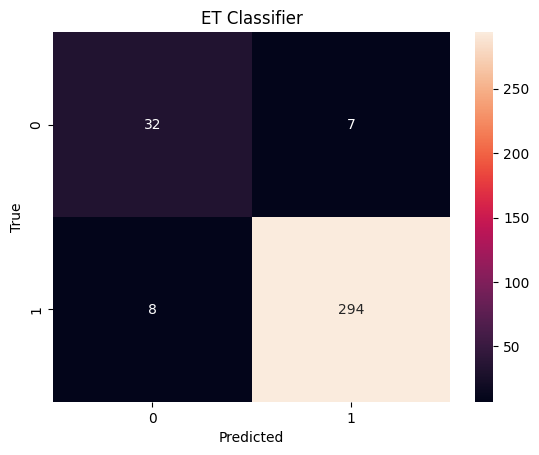

In [17]:
# plot the confusion matrix for the model
y_pred = best_ET.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ET Classifier')
plt.show()